In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
Y = Y[:, 2:]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([99677, 6])
normalized X mean: -1.1799484138211669
X std: 1.0505892613255765


In [6]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_3.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [5]:
def inference(model, total_size, batch_size, coeffs):
    num = total_size
    batchsize = batch_size
    n_gaussian = model.n_gaussian
    pis = torch.zeros((num, n_gaussian))
    locs = torch.zeros((num, n_gaussian, output_dim))
    scales = torch.zeros((num, n_gaussian, output_dim))
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(int(np.ceil(num / batchsize)))):
            batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
            pi, normal = model(batch)
            pis[i*batchsize:min(i*batchsize+batchsize, num)] = pi.probs.detach().cpu()
            locs[i*batchsize:min(i*batchsize+batchsize, num)] = normal.loc.detach().cpu()
            scales[i*batchsize:min(i*batchsize+batchsize, num)] = normal.scale.detach().cpu()
    return pis, locs, scales

def get_loglik(pi, loc, scale, x, margin_dim, exp=False):
    shape = x.shape
    loc = loc[..., margin_dim]
    scale = scale[..., margin_dim]
    normal = torch.distributions.Normal(loc, scale)
    x = x.reshape(-1, loc.shape[0], 1).tile(1, loc.shape[-1])
    loglik = normal.log_prob(x).reshape(*shape[:-1], -1)
    loglik = torch.logsumexp(torch.log(pi) + loglik, dim=-1)
    if exp:
        return torch.exp(loglik)
    return loglik

def get_peak_pred(pis, locs, scales, n_step=1000, verbose=False):
    num = len(pis); output_dim = locs.shape[-1]
    pred_global = torch.zeros((num, output_dim))
    pred_global_loglik = torch.zeros((num, output_dim))
    pred_close = torch.zeros((num, output_dim))
    pred_close_loglik = torch.zeros((num, output_dim))
    grid = [torch.linspace(0, 1, n_step),
            torch.linspace(-4, -2, n_step),
            torch.linspace(-4, 0, n_step),
            torch.linspace(-0.6, 0.6, n_step),
            torch.linspace(0, 2, n_step),
            torch.linspace(-1, 0, n_step)]
    for dim in tqdm(range(output_dim)):
        param_list = grid[dim].reshape(-1, 1, 1).tile(1, num, 1) 
        loglik = get_loglik(pis, locs, scales, param_list, margin_dim=dim, exp=False).transpose(1, 0)
        for i in tqdm(range(num)):
            peaks = find_peaks(loglik[i])[0]
            if len(peaks) == 0:
                pred_global[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_close[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_global_loglik[i, dim] = torch.max(loglik[i])
                pred_close_loglik[i, dim] = torch.max(loglik[i])
                if verbose:
                    print('no peak found, use maximum instead')
                    plt.plot(grid[dim], loglik[i])
                    plt.vlines(Y[i, dim], 0, 10, color='red')
                    plt.vlines(grid[dim][torch.argmax(loglik[i])], 0, 10, color='blue')
                    print(Y[i, dim])
                    plt.show()
            else:
                order = torch.argsort(loglik[i, peaks], descending=True)
                global_peak = grid[dim][peaks[order[0]]]
                close_peak = grid[dim][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
                pred_global[i, dim] = global_peak
                pred_close[i, dim] = close_peak
                pred_global_loglik[i, dim] = loglik[i][peaks[order[0]]]
                pred_close_loglik[i, dim] = loglik[i][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
    return pred_global, pred_global_loglik, pred_close, pred_close_loglik

def simulate_lc(t_0, t_E, u_0, lgrho, lgq, lgs, alpha_180, lgfs, relative_uncertainty=0, n_points=1000, orig=False, times=None):
    fs = 10**lgfs
    parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'rho': 10**lgrho, 
            'q': 10**lgq, 
            's': 10**lgs, 
            'alpha': alpha_180*180,
        }
    modelmm = mm.Model(parameters, coords=None)
    if times is None:
        times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=n_points)
    modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
    magnification = modelmm.get_magnification(times)
    flux = 1000 * (magnification + (1-fs)/fs)
    flux *= 1 + relative_uncertainty * np.random.randn(len(flux))
    if orig:
        mag = (22 - 2.5 * np.log10(flux) - 14.5 - 2.5*np.log10(fs))
    else:
        mag = (22 - 2.5 * np.log10(flux) - 14.5 - 2.5*np.log10(fs)) / 0.2
    lc = np.stack([times, mag], axis=-1)
    return lc

In [3]:
size = 4096

In [7]:
pis, locs, scales = inference(model, size, min(4096, size), coeffs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
pred = get_peak_pred(pis, locs, scales)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

In [9]:
np.save('./rescale_y.npy', Y[:size])
np.save('./rescale_pred.npy', pred)

/home/hmzhao/.conda/envs/ode-rnn/lib/python3.9/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/home/hmzhao/.conda/envs/ode-rnn/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [118]:
relative_uncertainty = 0.03
dchi2s = np.zeros((size,))
dparams = np.zeros((size, output_dim))
dparams = Y[:size] - pred[2][:size]

for i in tqdm(range(size)):
    times = X[i, :, 0].numpy()
    lc_true = simulate_lc(0, 1, *Y[i].tolist(), orig=True, times=times)
    param = pred[2][i].tolist()
    lc_pred = simulate_lc(0, 1, *param, orig=True, times=times)
    chi2_pred = np.sum(((X[i, :, 1].numpy()/5 - lc_pred[:, 1]) / (2.5 * np.log(10) * relative_uncertainty))**2)
    chi2 = np.sum(((X[i, :, 1].numpy()/5 - lc_true[:, 1]) / (2.5 * np.log(10) * relative_uncertainty))**2)
    dchi2s[i] = chi2_pred - chi2

  0%|          | 0/4096 [00:00<?, ?it/s]

In [ ]:
relative_uncertainty = 0.03
dchi2s = np.zeros((size, output_dim))
dparams = np.zeros((size, output_dim))
dparams = Y[:size] - pred[2][:size]

for i in tqdm(range(size)):
    lc_true = simulate_lc(0, 1, *Y[i].tolist(), orig=True)
    for dim in range(output_dim):
        param = Y[i].tolist()
        param[dim] = pred[2][i].tolist()[dim]
        lc_pred = simulate_lc(0, 1, *param, orig=True)
        dchi2 = np.sum(((lc_true[:, 1] - lc_pred[:, 1]) / (2.5 * np.log(10) * relative_uncertainty))**2)
        dchi2s[i, dim] = dchi2

In [119]:
np.save('./dchi2.npy', dchi2s)
np.save('./dparams.npy', dparams)

In [8]:
dchi2s = np.load('./dchi2.npy')
dparams = np.load('./dparams.npy')

In [ ]:
plt.scatter(pred[2][:, 3], np.log10(dchi2s[:]), label='dlgq-lgdchi2', alpha=0.2)
plt.legend()
plt.show()

/tmp/ipykernel_276023/877773715.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(dparams[:, 0], np.log10(dchi2s[:]), label='du0-lgdchi2', alpha=0.2)


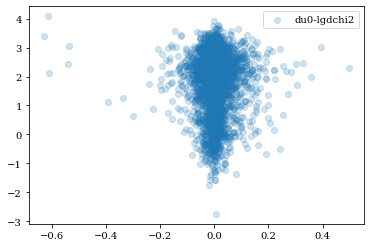

/tmp/ipykernel_276023/877773715.py:4: RuntimeWarning: invalid value encountered in log10
  plt.scatter(dparams[:, 2], np.log10(dchi2s[:]), label='dlgq-lgdchi2', alpha=0.2)


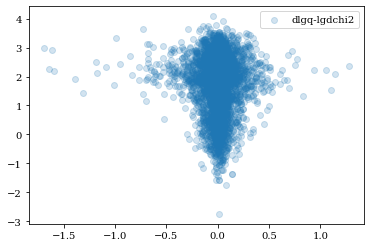

/tmp/ipykernel_276023/877773715.py:7: RuntimeWarning: invalid value encountered in log10
  plt.scatter(dparams[:, 3], np.log10(dchi2s[:]), label='dlgs-lgdchi2', alpha=0.2)


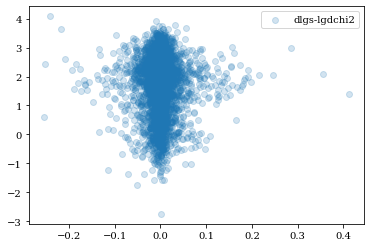

/tmp/ipykernel_276023/877773715.py:10: RuntimeWarning: invalid value encountered in log10
  plt.scatter(dparams[:, 4], np.log10(dchi2s[:]), label='dalpha/180-lgdchi2', alpha=0.2)


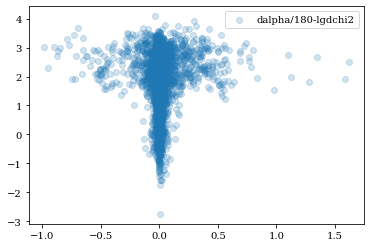

/tmp/ipykernel_276023/877773715.py:13: RuntimeWarning: invalid value encountered in log10
  plt.scatter(dparams[:, 5], np.log10(dchi2s[:]), label='dlgfs-lgdchi2', alpha=0.2)


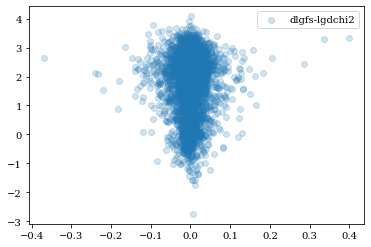

In [120]:
plt.scatter(dparams[:, 0], np.log10(dchi2s[:]), label='du0-lgdchi2', alpha=0.2)
plt.legend()
plt.show()
plt.scatter(dparams[:, 2], np.log10(dchi2s[:]), label='dlgq-lgdchi2', alpha=0.2)
plt.legend()
plt.show()
plt.scatter(dparams[:, 3], np.log10(dchi2s[:]), label='dlgs-lgdchi2', alpha=0.2)
plt.legend()
plt.show()
plt.scatter(dparams[:, 4], np.log10(dchi2s[:]), label='dalpha/180-lgdchi2', alpha=0.2)
plt.legend()
plt.show()
plt.scatter(dparams[:, 5], np.log10(dchi2s[:]), label='dlgfs-lgdchi2', alpha=0.2)
plt.legend()
plt.show()

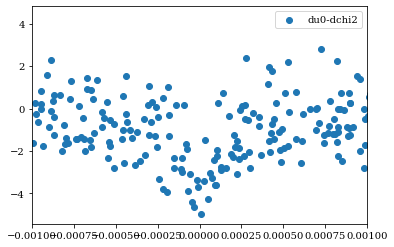

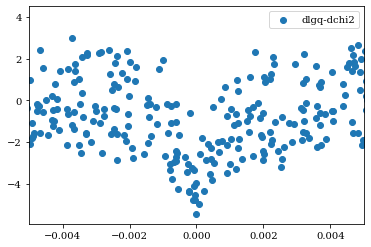

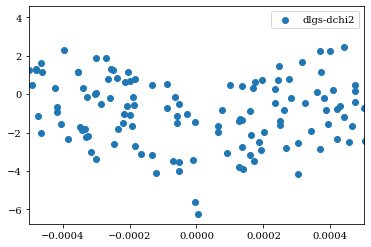

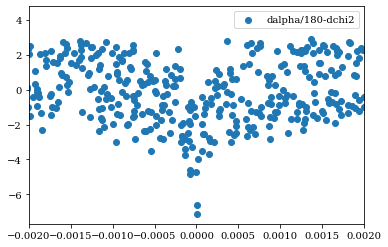

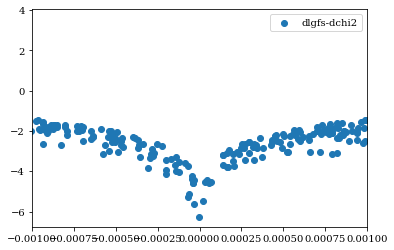

In [54]:
plt.scatter(dparams[:, 0], np.log10(dchi2s[:, 0]), label='du0-dchi2')
plt.xlim(-0.001, 0.001)
plt.legend()
plt.show()
plt.scatter(dparams[:, 2], np.log10(dchi2s[:, 2]), label='dlgq-dchi2')
plt.xlim(-0.005, 0.005)
plt.legend()
plt.show()
plt.scatter(dparams[:, 3], np.log10(dchi2s[:, 3]), label='dlgs-dchi2')
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.show()
plt.scatter(dparams[:, 4], np.log10(dchi2s[:, 4]), label='dalpha/180-dchi2')
plt.xlim(-0.002, 0.002)
plt.legend()
plt.show()
plt.scatter(dparams[:, 5], np.log10(dchi2s[:, 5]), label='dlgfs-dchi2')
plt.xlim(-0.001, 0.001)
plt.legend()
plt.show()

In [ ]:
dim = 4
m, bins, _ = plt.hist(dparams[:, dim], bins=20)
n, bins, _ = plt.hist(dparams[:, dim][np.log10(dchi2s[:, dim]) < 2], bins=bins)
plt.show()
plt.plot(bins[:-1], n/m)
plt.show()

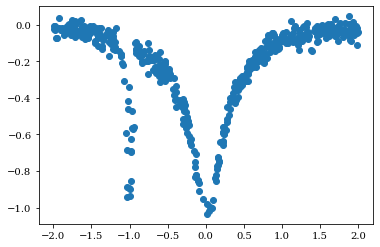

In [9]:
i = 3576
plt.scatter(X[i, :, 0], X[i, :, 1]/5)
lc = np.stack([X[i, :, 0], X[i, :, 1]/5], axis=-1)
np.savetxt('./lightcurve.csv', lc, delimiter=',', header='time, mag-m0')

In [14]:
i = 3576
lc_true = simulate_lc(0, 1, *Y[i].tolist(), orig=True)
param = pred[2][i].tolist()
# param[1] = -2.88
# param[2] = -0.5135
# param[0] = 0.144
# param[3] = 0.2036
# param[4] = 1.044
lc_pred = simulate_lc(0, 1, *param, orig=True)
dchi2 = np.mean((lc_true[:, 1] - lc_pred[:, 1])**2)

NameError: name 'dchi2s' is not defined

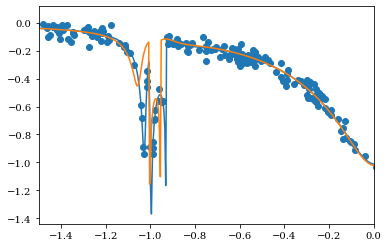

In [15]:
plt.scatter(X[i, :, 0], X[i, :, 1]/5)
plt.plot(np.linspace(-2, 2, 1000), lc_true[:, 1])
plt.plot(np.linspace(-2, 2, 1000), lc_pred[:, 1])
plt.xlim(-1.5, -0)
print(dchi2s[i])
print((dparams[i]**2).sum())
# print((dparams_norho[i]**2).sum())
print('params: u0, lgrho, lgq, lgs, alpha/180, lgfs')
print('truth: ', Y[i].numpy())
print('pred: ', pred[2][i].numpy())
print(param)

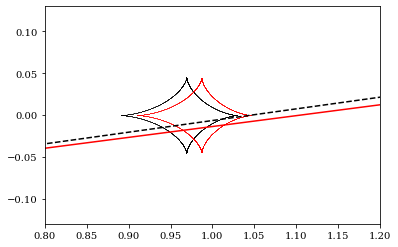

In [21]:
i = 3576
param_list = [Y[i].tolist(), pred[2][i].tolist()]
traj_color = ['black', 'red']
plt.axis('equal')
plt.xlim(0.8, 1.2)
plt.ylim(-0.1, 0.1)
for i, params in enumerate(param_list):
    u_0, lgrho, lgq, lgs, alpha_180, lgfs = params
    parameters = {
                't_0': 0,
                't_E': 1,
                'u_0': u_0,
                'rho': 10**lgrho, 
                'q': 10**lgq, 
                's': 10**lgs, 
                'alpha': alpha_180*180,
            }
    modelmm = mm.Model(parameters, coords=None)
    if i == 0:
        modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[i], linestyle='dashed')
    else:
        modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[i])
    modelmm.plot_caustics(color=traj_color[i], s=0.3)

/tmp/ipykernel_276023/963577164.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter((dparams**2).sum(dim=1), np.log10(dchi2s))


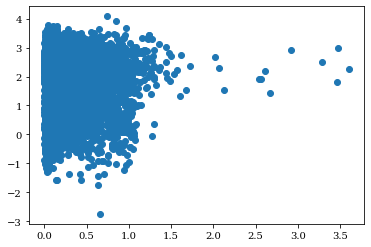

In [128]:
plt.scatter((dparams**2).sum(dim=1), np.log10(dchi2s))

In [129]:
dparams_norho = np.delete(dparams, 1, axis=1)

In [201]:
ind = np.arange(len(dchi2s))[(dparams_norho**2).sum(axis=1)<0.0001]
ind[np.log10(np.abs(dchi2s))[ind].argmax()], np.log10(np.abs(dchi2s))[ind].max()

(3572, 2.763778991884256)

In [200]:
torch.sum((dparams_norho**2).sum(axis=1)<0.0001)

tensor(18)

In [219]:
ind[np.log10(np.abs(dchi2s))[ind].argsort()]

array([2211, 1659,  888, 1192,  299,  145, 3221, 2515, 3186, 3216, 1323,
       2246, 3433, 3082, 3576, 1495,  433, 3572])